In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
!unzip Set5.zip

Archive:  Set5.zip
   creating: Set5/
  inflating: __MACOSX/._Set5         
  inflating: Set5/bird.png           
  inflating: __MACOSX/Set5/._bird.png  
  inflating: Set5/butterfly.png      
  inflating: __MACOSX/Set5/._butterfly.png  
  inflating: Set5/head.png           
  inflating: __MACOSX/Set5/._head.png  
  inflating: Set5/woman.png          
  inflating: __MACOSX/Set5/._woman.png  
  inflating: Set5/baby.png           
  inflating: __MACOSX/Set5/._baby.png  


In [ ]:
!unzip Set14.zip

Archive:  Set14.zip
   creating: Set14/
  inflating: __MACOSX/._Set14        
  inflating: Set14/monarch.png       
  inflating: __MACOSX/Set14/._monarch.png  
  inflating: Set14/flowers.png       
  inflating: __MACOSX/Set14/._flowers.png  
  inflating: Set14/bridge.png        
  inflating: __MACOSX/Set14/._bridge.png  
  inflating: Set14/ppt3.png          
  inflating: __MACOSX/Set14/._ppt3.png  
  inflating: Set14/zebra.png         
  inflating: __MACOSX/Set14/._zebra.png  
  inflating: Set14/lenna.png         
  inflating: __MACOSX/Set14/._lenna.png  
  inflating: Set14/barbara.png       
  inflating: __MACOSX/Set14/._barbara.png  
  inflating: Set14/face.png          
  inflating: __MACOSX/Set14/._face.png  
  inflating: Set14/comic.png         
  inflating: __MACOSX/Set14/._comic.png  
  inflating: Set14/pepper.png        
  inflating: __MACOSX/Set14/._pepper.png  
  inflating: Set14/man.png           
  inflating: __MACOSX/Set14/._man.png  
  inflating: Set14/coastguard.png    


In [ ]:
# Declaring Constants
IMAGE_PATH = "./Set5/baby.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


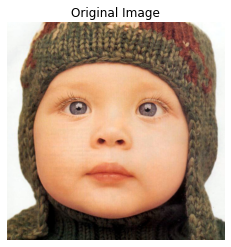

In [ ]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 10.166208


Saved as Super Resolution.jpg


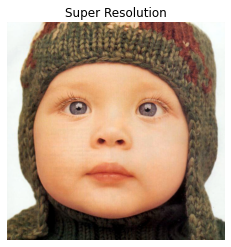

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [ ]:
IMAGE_PATH = './Set5/woman.png'

In [ ]:
# Lets avaluate the performance by creating the super resolution imgae from low res image
#method to downscale the image
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    print (len(image.shape))
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

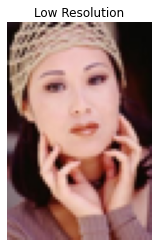

In [ ]:
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.181367


PSNR Achieved: 28.226719


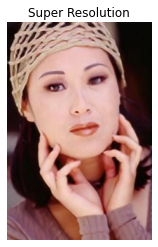

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 28.226719


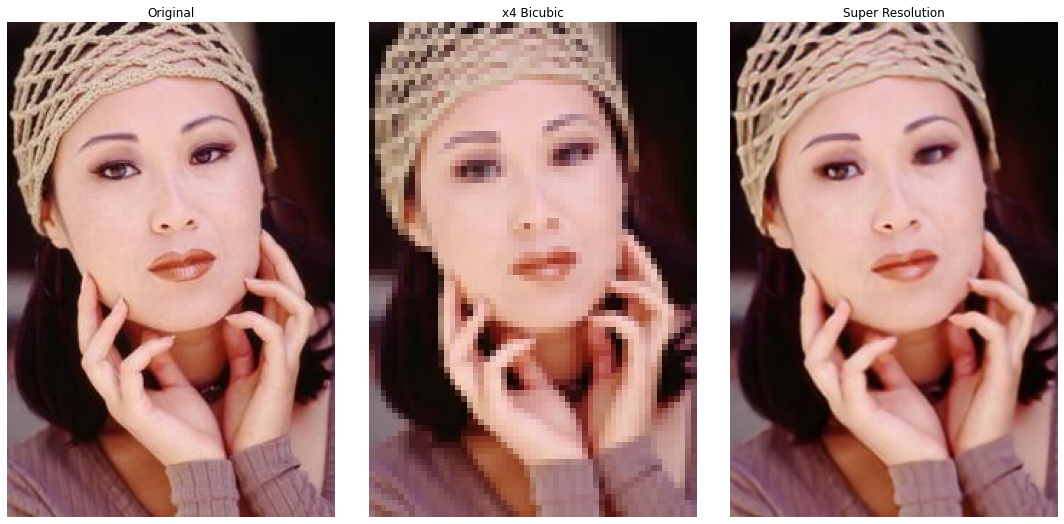

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [ ]:
import glob
import cv2


In [ ]:
list_psnr = []
list_ssim = []
for file in glob.glob('./Set5/*.png'):
  hr_image = preprocess_image(file)
  lr_image = downscale_image(tf.squeeze(hr_image))
  start = time.time()
  fake_image = model(lr_image)
  fake_image = tf.squeeze(fake_image)
  print (file)
  print("Time Taken: %f" % (time.time() - start))
  # Calculating PSNR wrt Original Image
  psnr = tf.image.psnr(
  tf.clip_by_value(fake_image, 0, 255),
  tf.clip_by_value(hr_image, 0, 255), max_val=255)
  list_psnr.append(psnr)
  #ssim calculation with the original image
  ssim = tf.image.ssim(tf.clip_by_value(fake_image, 0, 255),
  tf.clip_by_value(hr_image, 0, 255), max_val=255)
  list_ssim.append(ssim)
  print("PSNR Achieved: %f" % psnr)
  print("SSIM Achieved: %f" % ssim)

  


./Set5/butterfly.png
Time Taken: 1.130719
PSNR Achieved: 25.305735
SSIM Achieved: 0.851745
./Set5/bird.png
Time Taken: 1.012902
PSNR Achieved: 31.028080
SSIM Achieved: 0.884169


./Set5/head.png
Time Taken: 1.021294
PSNR Achieved: 29.440359
SSIM Achieved: 0.698630


./Set5/baby.png
Time Taken: 1.225855
PSNR Achieved: 31.030960
SSIM Achieved: 0.835015
./Set5/woman.png
Time Taken: 0.013431
PSNR Achieved: 28.226719
SSIM Achieved: 0.875397


In [ ]:
mean_psnr= np.mean(list_psnr)

In [ ]:
mean_ssim = np.mean(list_ssim)

In [ ]:
print (mean_psnr, mean_ssim)

29.006372 0.8289911


In [ ]:
list_psnr = []
list_ssim = []
for file in glob.glob('./Set14/*.png'):
  hr_image = preprocess_image(file)
  lr_image = downscale_image(tf.squeeze(hr_image))
  start = time.time()
  fake_image = model(lr_image)
  fake_image = tf.squeeze(fake_image)
  print (file)
  print("Time Taken: %f" % (time.time() - start))
  # Calculating PSNR wrt Original Image
  psnr = tf.image.psnr(
  tf.clip_by_value(fake_image, 0, 255),
  tf.clip_by_value(hr_image, 0, 255), max_val=255)
  list_psnr.append(psnr)
  #ssim calculation with the original image
  ssim = tf.image.ssim(tf.clip_by_value(fake_image, 0, 255),
  tf.clip_by_value(hr_image, 0, 255), max_val=255)
  list_ssim.append(ssim)
  print("PSNR Achieved: %f" % psnr)
  print("SSIM Achieved: %f" % ssim)

./Set14/lenna.png
Time Taken: 0.030293
PSNR Achieved: 29.494429
SSIM Achieved: 0.758050
./Set14/foreman.png
Time Taken: 0.018456
PSNR Achieved: 28.267817
SSIM Achieved: 0.875043
./Set14/comic.png
Time Taken: 0.018562
PSNR Achieved: 21.065187
SSIM Achieved: 0.663438
./Set14/zebra.png
Time Taken: 0.038667
PSNR Achieved: 25.080153
SSIM Achieved: 0.725142
./Set14/pepper.png
Time Taken: 0.019124
PSNR Achieved: 28.616858
SSIM Achieved: 0.762360
./Set14/man.png
Time Taken: 0.018530
PSNR Achieved: 25.461939
SSIM Achieved: 0.694481
./Set14/face.png
Time Taken: 0.018520
PSNR Achieved: 29.410252
SSIM Achieved: 0.696713
./Set14/coastguard.png
Time Taken: 0.018169
PSNR Achieved: 24.096687
SSIM Achieved: 0.505693
./Set14/monarch.png
Time Taken: 0.022483
PSNR Achieved: 30.084023
SSIM Achieved: 0.908467
./Set14/ppt3.png
Time Taken: 0.029682
PSNR Achieved: 24.111292
SSIM Achieved: 0.884743


In [ ]:
mean_psnr= np.mean(list_psnr)

In [ ]:
mean_ssim = np.mean(list_ssim)

In [ ]:
print (mean_psnr, mean_ssim)

26.568863 0.74741304
